#   K means Agglomerative DBSCAN clustering algorithms on Donors Choose dataset

DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website. Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve: How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible How to increase the consistency of project vetting across different volunteers to improve the experience for teachers How to focus volunteer time on the applications that need the most assistance

The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import chart_studio.plotly as py
from scipy.sparse import hstack
import chart_studio.plotly as py


from collections import Counter

## 1. LOAD AND PROCESS DATA

### 1.1 Reading Data

In [2]:
data=pd.read_csv("train_data.csv",nrows=50000)
resource_data=pd.read_csv("resources.csv")
data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved'],
      dtype='object')

In [3]:
price_data=resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()

In [4]:
project_data=pd.merge(data, price_data, on='id', how='left')

In [5]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_subject_categories', 'project_subject_subcategories',
       'project_title', 'project_essay_1', 'project_essay_2',
       'project_essay_3', 'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'price', 'quantity'],
      dtype='object')

### 1.2 process Project Essay

In [6]:
project_data.head(3)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,price,quantity
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Literacy & Language,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,154.60,23
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"History & Civics, Health & Sports","Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,299.00,1
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms.,AZ,2016-08-31 12:03:56,Grades 6-8,Health & Sports,"Health & Wellness, Team Sports",Soccer Equipment for AWESOME Middle School Stu...,"\r\n\""True champions aren't always the ones th...",The students on the campus come to school know...,NaN,NaN,"My students need shine guards, athletic socks,...",1,0,516.85,22


In [7]:
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                project_data["project_essay_2"].map(str) + \
                project_data["project_essay_3"].map(str) + \
                project_data["project_essay_4"].map(str)

In [8]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [9]:
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [10]:
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays.append(sent.lower().strip())
project_data['cleaned_essay']=preprocessed_essays

100%|██████████| 50000/50000 [00:27<00:00, 1818.44it/s]


### 1.2 process Project Title

In [11]:
# https://stackoverflow.com/a/47091490/4084039
from tqdm import tqdm
preprocessed_title = []
# tqdm is for printing the status bar
for sentance in tqdm(data['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_title.append(sent.lower().strip())
project_data['cleaned_project_title']=preprocessed_title

100%|██████████| 50000/50000 [00:01<00:00, 37055.84it/s]


### 1.3 teacher_prefix

In [12]:
temp1=data.teacher_prefix.apply(lambda x: str(x).replace('.', ''))
project_data['teacher_prefix']=temp1
project_data['teacher_prefix'].value_counts()


Mrs        26140
Ms         17936
Mr          4859
Teacher     1061
Dr             2
nan            2
Name: teacher_prefix, dtype: int64

### 1.4 project grade

In [13]:
project_data.project_grade_category.value_counts()

Grades PreK-2    20316
Grades 3-5       16968
Grades 6-8        7750
Grades 9-12       4966
Name: project_grade_category, dtype: int64

In [14]:
grade_list=[]
for i in project_data['project_grade_category'].values:
    i=i.replace(' ','_')
    i=i.replace('-','_')
    grade_list.append(i.strip()) 
    
    
project_data['project_grade_category']=grade_list  
       
   

In [15]:
project_data['project_grade_category'].value_counts()

Grades_PreK_2    20316
Grades_3_5       16968
Grades_6_8        7750
Grades_9_12       4966
Name: project_grade_category, dtype: int64

### 1.5 project_subject_categories

In [16]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())
    
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)

from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))

### 1.6 project_subject_subcategories

In [17]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)

# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

### 1.7 counting words in title

In [18]:
#https://stackoverflow.com/questions/49984905/count-number-of-words-per-row
project_data['totalwords_title'] = project_data['cleaned_project_title'].str.split().str.len()

### 1.8 number of words in the essay

In [19]:
project_data['totalwords_essay'] = project_data['cleaned_essay'].str.split().str.len()

### 1.9 sentiment score's of each of the essay

In [20]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
neg=[]
compound=[]
pos=[]
neu=[]
for sent in (project_data['cleaned_essay'].values):
    score = analyser.polarity_scores(sent)
    neg.append(score.get('neg'))
    neu.append(score.get('neu'))
    pos.append(score.get('pos'))
    compound.append(score.get('compound'))
project_data['neg']=neg
project_data['neu']=neu
project_data['pos']=pos
project_data['compound']=compound

### 1.10 droping unnecesarry columns

In [21]:
project_data.drop(['project_title'], axis=1, inplace=True)
project_data.drop(['project_essay_1'], axis=1, inplace=True)
project_data.drop(['project_essay_2'], axis=1, inplace=True)
project_data.drop(['project_essay_3'], axis=1, inplace=True)
project_data.drop(['project_essay_4'], axis=1, inplace=True)

In [22]:
project_data.head(3)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,...,cleaned_essay,cleaned_project_title,clean_categories,clean_subcategories,totalwords_title,totalwords_essay,neg,neu,pos,compound
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs,IN,2016-12-05 13:43:57,Grades_PreK_2,My students need opportunities to practice beg...,0,0,...,my students english learners working english s...,educational support english learners home,Literacy_Language,ESL Literacy,5,161,0.012,0.845,0.143,0.9694
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr,FL,2016-10-25 09:22:10,Grades_6_8,My students need a projector to help with view...,7,1,...,our students arrive school eager learn they po...,wanted projector hungry learners,History_Civics Health_Sports,Civics_Government TeamSports,4,109,0.048,0.668,0.284,0.9860
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms,AZ,2016-08-31 12:03:56,Grades_6_8,"My students need shine guards, athletic socks,...",1,0,...,true champions not always ones win guts by mia...,soccer equipment awesome middle school students,Health_Sports,Health_Wellness TeamSports,6,202,0.076,0.656,0.268,0.9939


### 1.11 Making dependant(label) and independant variables

In [23]:
y = project_data['project_is_approved'].values

project_data.head(1)
x=project_data
x.head(3)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,...,cleaned_essay,cleaned_project_title,clean_categories,clean_subcategories,totalwords_title,totalwords_essay,neg,neu,pos,compound
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs,IN,2016-12-05 13:43:57,Grades_PreK_2,My students need opportunities to practice beg...,0,0,...,my students english learners working english s...,educational support english learners home,Literacy_Language,ESL Literacy,5,161,0.012,0.845,0.143,0.9694
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr,FL,2016-10-25 09:22:10,Grades_6_8,My students need a projector to help with view...,7,1,...,our students arrive school eager learn they po...,wanted projector hungry learners,History_Civics Health_Sports,Civics_Government TeamSports,4,109,0.048,0.668,0.284,0.9860
2,21895,p182444,3465aaf82da834c0582ebd0ef8040ca0,Ms,AZ,2016-08-31 12:03:56,Grades_6_8,"My students need shine guards, athletic socks,...",1,0,...,true champions not always ones win guts by mia...,soccer equipment awesome middle school students,Health_Sports,Health_Wellness TeamSports,6,202,0.076,0.656,0.268,0.9939


### 1.12 Traing and Test split

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.33, stratify=y,random_state=42)

#X_train, X_cv, Y_train, Y_cv = train_test_split(X_train,Y_train, test_size=0.33, stratify=Y_train,random_state=42)

## 2.Text Vectorization and encoding catagories,normalization numerical features

### 2.1 converting the essay to vectors using BOW

In [25]:

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer.fit(X_train['cleaned_essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_bow = vectorizer.transform(X_train['cleaned_essay'].values)
#X_cv_essay_bow = vectorizer.transform(X_cv['cleaned_essay'].values)
X_test_essay_bow = vectorizer.transform(X_test['cleaned_essay'].values)

print("After vectorizations")
print(X_train_essay_bow.shape, Y_train.shape)
print(X_test_essay_bow.shape, Y_test.shape)
#print(X_cv_essay_bow.shape, Y_cv.shape)
print("="*100)

After vectorizations
(33500, 5000) (33500,)
(16500, 5000) (16500,)


### 2.2 converting the title to vectors using BOW

In [26]:
vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer.fit(X_train['cleaned_project_title'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_title_bow = vectorizer.transform(X_train['cleaned_project_title'].values)
#X_cv_title_bow = vectorizer.transform(X_cv['cleaned_project_title'].values)
X_test_title_bow = vectorizer.transform(X_test['cleaned_project_title'].values)

print("After vectorizations")
print(X_train_title_bow.shape, Y_train.shape)
#print(X_cv_title_bow.shape, Y_cv.shape)
print(X_test_title_bow.shape, Y_test.shape)
print("="*100)

After vectorizations
(33500, 2902) (33500,)
(16500, 2902) (16500,)


### 2.3 converting the title to vectors using TFIDF

In [27]:
vectorizer = TfidfVectorizer(min_df=10)
vectorizer.fit(X_train['cleaned_project_title'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_title_tfidf = vectorizer.transform(X_train['cleaned_project_title'].values)
#X_cv_title_tfidf = vectorizer.transform(X_cv['cleaned_project_title'].values)
X_test_title_tfidf = vectorizer.transform(X_test['cleaned_project_title'].values)

print("After vectorizations")
print(X_train_title_tfidf.shape, Y_train.shape)
#print(X_cv_title_tfidf.shape, Y_cv.shape)
print(X_test_title_tfidf.shape, Y_test.shape)
print("="*100)

After vectorizations
(33500, 1629) (33500,)
(16500, 1629) (16500,)


### 2.4 converting the essay to vectors using TFIDF

In [28]:
vectorizer = TfidfVectorizer(min_df=10)
vectorizer.fit(X_train['cleaned_essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_tfidf = vectorizer.transform(X_train['cleaned_essay'].values)
#X_cv_essay_tfidf = vectorizer.transform(X_cv['cleaned_essay'].values)
X_test_essay_tfidf = vectorizer.transform(X_test['cleaned_essay'].values)

print("After vectorizations")
print(X_train_essay_tfidf.shape, Y_train.shape)
#print(X_cv_essay_tfidf.shape, Y_cv.shape)
print(X_test_essay_tfidf.shape, Y_test.shape)
print("="*100)

After vectorizations
(33500, 10434) (33500,)
(16500, 10434) (16500,)


### 2.5 load glove mode

In [29]:
# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model
model = loadGloveModel('glove.42B.300d.txt')

# ============================
'''Output:
    
Loading Glove Model
1917495it [06:32, 4879.69it/s]
Done. 1917495  words loaded!
'''
# ============================

754it [00:00, 7538.50it/s]

Loading Glove Model


1917495it [03:57, 8067.29it/s]

Done. 1917495  words loaded!


'Output:\n    \nLoading Glove Model\n1917495it [06:32, 4879.69it/s]\nDone. 1917495  words loaded!\n'

In [30]:

words = []
for i in X_train['cleaned_essay'].values:
    words.extend(i.split(' '))

for i in X_train['cleaned_project_title'].values:
    words.extend(i.split(' '))
print("all the words in the coupus", len(words))
words = set(words)
print("the unique words in the coupus", len(words))

inter_words = set(model.keys()).intersection(words)
print("The number of words that are present in both glove vectors and our coupus", \
      len(inter_words),"(",np.round(len(inter_words)/len(words)*100,3),"%)")

words_courpus = {}
words_glove = set(model.keys())
for i in words:
    if i in words_glove:
        words_courpus[i] = model[i]
print("word 2 vec length", len(words_courpus))


# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

import pickle
with open('glove_vectors', 'wb') as f:
    pickle.dump(words_courpus, f)

all the words in the coupus 5220928
the unique words in the coupus 36812
The number of words that are present in both glove vectors and our coupus 34156 ( 92.785 %)
word 2 vec length 34156


In [31]:

# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

### 2.6 Avg w2v on essay

In [32]:
Text_avg_w2v_train_essay= []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['cleaned_essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    Text_avg_w2v_train_essay.append(vector)

print(len(Text_avg_w2v_train_essay))
print(len(Text_avg_w2v_train_essay[0]))

100%|██████████| 33500/33500 [00:11<00:00, 3031.38it/s]

33500
300


In [33]:
""" Text_avg_w2v_cv_essay= []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['cleaned_essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    Text_avg_w2v_cv_essay.append(vector)

print(len(Text_avg_w2v_cv_essay))
print(len(Text_avg_w2v_cv_essay[0])) """


" Text_avg_w2v_cv_essay= []; # the avg-w2v for each sentence/review is stored in this list\nfor sentence in tqdm(X_cv['cleaned_essay'].values): # for each review/sentence\n    vector = np.zeros(300) # as word vectors are of zero length\n    cnt_words =0; # num of words with a valid vector in the sentence/review\n    for word in sentence.split(): # for each word in a review/sentence\n        if word in glove_words:\n            vector += model[word]\n            cnt_words += 1\n    if cnt_words != 0:\n        vector /= cnt_words\n    Text_avg_w2v_cv_essay.append(vector)\n\nprint(len(Text_avg_w2v_cv_essay))\nprint(len(Text_avg_w2v_cv_essay[0])) "

In [34]:
Text_avg_w2v_test_essay= []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['cleaned_essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    Text_avg_w2v_test_essay.append(vector)

print(len(Text_avg_w2v_test_essay))
print(len(Text_avg_w2v_test_essay[0]))

100%|██████████| 16500/16500 [00:05<00:00, 3050.14it/s]

16500
300


### 2.7 Avg w2v on title

In [35]:
Text_avg_w2v_train_title= []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['cleaned_project_title'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    Text_avg_w2v_train_title.append(vector)

print(len(Text_avg_w2v_train_title))
print(len(Text_avg_w2v_train_title[0]))

100%|██████████| 33500/33500 [00:00<00:00, 65437.90it/s]

33500
300


In [36]:
"""Text_avg_w2v_cv_title= []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['cleaned_project_title'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    Text_avg_w2v_cv_title.append(vector)

print(len(Text_avg_w2v_cv_title))
print(len(Text_avg_w2v_cv_title[0])) """

"Text_avg_w2v_cv_title= []; # the avg-w2v for each sentence/review is stored in this list\nfor sentence in tqdm(X_cv['cleaned_project_title'].values): # for each review/sentence\n    vector = np.zeros(300) # as word vectors are of zero length\n    cnt_words =0; # num of words with a valid vector in the sentence/review\n    for word in sentence.split(): # for each word in a review/sentence\n        if word in glove_words:\n            vector += model[word]\n            cnt_words += 1\n    if cnt_words != 0:\n        vector /= cnt_words\n    Text_avg_w2v_cv_title.append(vector)\n\nprint(len(Text_avg_w2v_cv_title))\nprint(len(Text_avg_w2v_cv_title[0])) "

In [37]:
Text_avg_w2v_test_title= []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['cleaned_project_title'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    Text_avg_w2v_test_title.append(vector)

print(len(Text_avg_w2v_test_title))
print(len(Text_avg_w2v_test_title[0]))

100%|██████████| 16500/16500 [00:00<00:00, 62936.13it/s]

16500
300


### 2.4 TFIDF weighted W2V on essay

In [38]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['cleaned_essay'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [39]:

Text_tfidf_w2v_train_essay= []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['cleaned_essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    Text_tfidf_w2v_train_essay.append(vector)

print(len(Text_tfidf_w2v_train_essay))
print(len(Text_tfidf_w2v_train_essay[0]))

100%|██████████| 33500/33500 [01:24<00:00, 396.21it/s]

33500
300


In [40]:

"""Text_tfidf_w2v_cv_essay= []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['cleaned_essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    Text_tfidf_w2v_cv_essay.append(vector)

print(len(Text_tfidf_w2v_cv_essay))
print(len(Text_tfidf_w2v_cv_essay[0]))"""

"Text_tfidf_w2v_cv_essay= []; # the avg-w2v for each sentence/review is stored in this list\nfor sentence in tqdm(X_cv['cleaned_essay'].values): # for each review/sentence\n    vector = np.zeros(300) # as word vectors are of zero length\n    tf_idf_weight =0; # num of words with a valid vector in the sentence/review\n    for word in sentence.split(): # for each word in a review/sentence\n        if (word in glove_words) and (word in tfidf_words):\n            vec = model[word] # getting the vector for each word\n            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))\n            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word\n            vector += (vec * tf_idf) # calculating tfidf weighted w2v\n            tf_idf_weight += tf_idf\n    if tf_idf_weight != 0:\n        vector /= tf_idf_weight\n    Text_tfidf_w2v_cv_essay.append(vector)\n\nprint(len(Tex

In [41]:
Text_tfidf_w2v_test_essay= []; 
for sentence in tqdm(X_test['cleaned_essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    Text_tfidf_w2v_test_essay.append(vector)

print(len(Text_tfidf_w2v_test_essay))
print(len(Text_tfidf_w2v_test_essay[0]))

100%|██████████| 16500/16500 [00:40<00:00, 403.02it/s]

16500
300


### 2.5 TFIDF weighted W2V on title

In [42]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train['cleaned_project_title'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [43]:

Text_tfidf_w2v_train_title= []; 
for sentence in tqdm(X_train['cleaned_project_title'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    Text_tfidf_w2v_train_title.append(vector)

print(len(Text_tfidf_w2v_train_title))
print(len(Text_tfidf_w2v_train_title[0]))

100%|██████████| 33500/33500 [00:01<00:00, 28519.60it/s]

33500
300


In [44]:

"""Text_tfidf_w2v_cv_title= []; 
for sentence in tqdm(X_cv['cleaned_project_title'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    Text_tfidf_w2v_cv_title.append(vector)

print(len(Text_tfidf_w2v_cv_title))
print(len(Text_tfidf_w2v_cv_title[0])) """

"Text_tfidf_w2v_cv_title= []; \nfor sentence in tqdm(X_cv['cleaned_project_title'].values): # for each review/sentence\n    vector = np.zeros(300) # as word vectors are of zero length\n    tf_idf_weight =0; # num of words with a valid vector in the sentence/review\n    for word in sentence.split(): # for each word in a review/sentence\n        if (word in glove_words) and (word in tfidf_words):\n            vec = model[word] # getting the vector for each word\n            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))\n            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word\n            vector += (vec * tf_idf) # calculating tfidf weighted w2v\n            tf_idf_weight += tf_idf\n    if tf_idf_weight != 0:\n        vector /= tf_idf_weight\n    Text_tfidf_w2v_cv_title.append(vector)\n\nprint(len(Text_tfidf_w2v_cv_title))\nprint(len(Text_tfidf_w2v_cv_t

In [45]:
Text_tfidf_w2v_test_title= []; 
for sentence in tqdm(X_test['cleaned_project_title'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    Text_tfidf_w2v_test_title.append(vector)

print(len(Text_tfidf_w2v_test_title))
print(len(Text_tfidf_w2v_test_title[0]))

100%|██████████| 16500/16500 [00:00<00:00, 29576.28it/s]

16500
300


In [46]:
X_train.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category',
       'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'price', 'quantity', 'essay', 'cleaned_essay', 'cleaned_project_title',
       'clean_categories', 'clean_subcategories', 'totalwords_title',
       'totalwords_essay', 'neg', 'neu', 'pos', 'compound'],
      dtype='object')

### 2.6 Categories with response coding

In [47]:
def Responsetable(table, col) :
    cat = table[col].unique()
    alpha=1
    freq_Pos = []
    for i in cat : 
        freq_Pos.append(len(table.loc[(table[col] == i) & (table['project_is_approved'] == 1)]))
        
        
    freq_Neg = []
    for i in cat : 
        freq_Neg.append(len(table.loc[(table[col] == i) & (table['project_is_approved'] == 0)]))
        
    
    encoded_Pos = []
    for i in range(len(cat)) :
        encoded_Pos.append(((freq_Pos[i]+alpha)/(freq_Pos[i] + freq_Neg[i]+alpha)))
    
    encoded_Neg = []
    encoded_Neg[:] = [1 - x for x in encoded_Pos]
        
    encoded_Pos_val = dict(zip(cat, encoded_Pos)) 
    encoded_Neg_val = dict(zip(cat, encoded_Neg)) 
    
    return encoded_Pos_val, encoded_Neg_val

In [48]:
def Responsecode(table) : 
    pos_cleancat, neg_cleancat = Responsetable(table,'clean_categories')
    pos_cleansubcat, neg_cleansubcat = Responsetable(table,'clean_subcategories')
    pos_schoolstate, neg_schoolstate = Responsetable(table, 'school_state')
    pos_teacherprefix, neg_teacherprefix = Responsetable(table, 'teacher_prefix')
    pos_projgradecat, neg_projgradecat = Responsetable(table, 'project_grade_category')
    
    df = pd.DataFrame()
    df['clean_cat_pos'] = table['clean_categories'].map(pos_cleancat)
    df['clean_cat_neg'] = table['clean_categories'].map(neg_cleancat)
    df['clean_subcat_pos'] = table['clean_subcategories'].map(pos_cleansubcat)
    df['clean_subcat_neg'] = table['clean_subcategories'].map(neg_cleansubcat)
    df['school_state_pos'] = table['school_state'].map(pos_schoolstate)
    df['school_state_neg'] = table['school_state'].map(neg_schoolstate)
    df['teacher_prefix_pos'] = table['teacher_prefix'].map(pos_teacherprefix)
    df['teacher_prefix_neg'] = table['teacher_prefix'].map(neg_teacherprefix)
    df['proj_grade_cat_pos'] = table['project_grade_category'].map(pos_projgradecat)
    df['proj_grade_cat_neg'] = table['project_grade_category'].map(neg_projgradecat)

    return df

In [49]:
newTrain = Responsecode(X_train)
newTest = Responsecode(X_test)
#newCv=Responsecode(X_cv)

In [50]:
def mergeEncoding(table, p, n) :
    lstPos = table[p].values.tolist()
    lstNeg = table[n].values.tolist()
    frame = pd.DataFrame(list(zip(lstNeg, lstPos)))
    
    return frame

### 2.7  response code of clean_categories

In [51]:
X_train_clean_cat_resposecode = mergeEncoding(newTrain, 'clean_cat_pos', 'clean_cat_neg')
X_test_clean_cat_resposecode = mergeEncoding(newTest, 'clean_cat_pos', 'clean_cat_neg')
#X_cv_clean_cat_resposecode=mergeEncoding(newCv, 'clean_cat_pos', 'clean_cat_neg')
print(X_train_clean_cat_resposecode.shape)

(33500, 2)


### 2.8 response code of clean_sub_categories

In [52]:
X_train_clean_subcat_resposecode = mergeEncoding(newTrain, 'clean_subcat_pos', 'clean_subcat_neg')
X_test_clean_subcat_resposecode = mergeEncoding(newTest, 'clean_subcat_pos', 'clean_subcat_neg')
#X_cv_clean_subcat_resposecode = mergeEncoding(newCv, 'clean_subcat_pos', 'clean_subcat_neg')
print(X_train_clean_subcat_resposecode.shape)
print(X_test_clean_subcat_resposecode.shape)
#print(X_cv_clean_subcat_resposecode.shape)

(33500, 2)
(16500, 2)


### 2.9 response code of project grade

In [53]:
X_train_grade_resposecode = mergeEncoding(newTrain, 'proj_grade_cat_pos', 'proj_grade_cat_neg')
X_test_grade_resposecode = mergeEncoding(newTest, 'proj_grade_cat_pos', 'proj_grade_cat_neg')
#X_cv_grade_resposecode = mergeEncoding(newCv, 'proj_grade_cat_pos', 'proj_grade_cat_neg')
print(X_train_grade_resposecode.shape)
print(X_test_grade_resposecode.shape)
#print(X_cv_grade_resposecode.shape)

(33500, 2)
(16500, 2)


### 2.10 response code of school state

In [54]:
X_train_state_resposecode = mergeEncoding(newTrain, 'school_state_pos', 'school_state_neg')
X_test_state_resposecode = mergeEncoding(newTest, 'school_state_pos', 'school_state_neg')
#X_cv_state_resposecode = mergeEncoding(newCv, 'school_state_pos', 'school_state_neg')
print(X_train_state_resposecode.shape)
print(X_test_state_resposecode.shape)
#print(X_cv_state_resposecode.shape)

(33500, 2)
(16500, 2)


### 2.11 response code of teacher prefix

In [55]:
X_train_teacher_resposecode = mergeEncoding(newTrain, 'teacher_prefix_pos', 'teacher_prefix_neg')
X_test_teacher_resposecode = mergeEncoding(newTest, 'teacher_prefix_pos', 'teacher_prefix_neg')
#X_cv_teacher_resposecode = mergeEncoding(newCv, 'teacher_prefix_pos', 'teacher_prefix_neg')
print(X_train_teacher_resposecode.shape)
print(X_test_teacher_resposecode.shape)
#print(X_cv_teacher_resposecode.shape)

(33500, 2)
(16500, 2)


### 2.12 Normalizing the numerical features: Price

In [56]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['price'].values.reshape(-1,1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))

X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(-1,1))

#X_cv_price_norm = normalizer.transform(X_cv['price'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_price_norm.shape, Y_train.shape)
#print(X_cv_price_norm.shape, Y_cv.shape)
print(X_test_price_norm.shape, Y_test.shape)
print("="*100)

After vectorizations
(33500, 1) (33500,)
(16500, 1) (16500,)


### 2.13 Normalizing the numerical features:teacher_number_of_previously_posted_projects

In [57]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

X_train_TPPP_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
#X_cv_TPPP_norm = normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_TPPP_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_TPPP_norm.shape, Y_train.shape)
#print(X_cv_TPPP_norm.shape, Y_cv.shape)
print(X_test_TPPP_norm.shape, Y_test.shape)
print("="*100)

After vectorizations
(33500, 1) (33500,)
(16500, 1) (16500,)


### 2.14 Normalizing the numerical features: quantity

In [58]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['quantity'].values.reshape(-1,1))

X_train_quantity_norm = normalizer.transform(X_train['quantity'].values.reshape(-1,1))
#X_cv_quantity_norm = normalizer.transform(X_cv['quantity'].values.reshape(-1,1))
X_test_quantity_norm = normalizer.transform(X_test['quantity'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_quantity_norm.shape, Y_train.shape)
#print(X_cv_quantity_norm.shape, Y_cv.shape)
print(X_test_quantity_norm.shape, Y_test.shape)
print("="*100)

After vectorizations
(33500, 1) (33500,)
(16500, 1) (16500,)


### 2.15 Normalizing the numerical features: totalwords_title

In [59]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['totalwords_title'].values.reshape(-1,1))

X_train_totalwords_title_norm = normalizer.transform(X_train['totalwords_title'].values.reshape(-1,1))

X_test_totalwords_title_norm = normalizer.transform(X_test['totalwords_title'].values.reshape(-1,1))
#X_cv_totalwords_title_norm = normalizer.transform(X_cv['totalwords_title'].values.reshape(-1,1))
print("After vectorizations")
print(X_train_totalwords_title_norm.shape, Y_train.shape)
#print(X_cv_totalwords_title_norm.shape, Y_cv.shape)
print(X_test_totalwords_title_norm.shape, Y_test.shape)
print("="*100)

After vectorizations
(33500, 1) (33500,)
(16500, 1) (16500,)


### 2.17 Normalizing the numerical features: totalwords_essay

In [60]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

normalizer.fit(X_train['totalwords_essay'].values.reshape(-1,1))

X_train_totalwords_essay_norm = normalizer.transform(X_train['totalwords_essay'].values.reshape(-1,1))
#X_cv_totalwords_essay_norm = normalizer.transform(X_cv['totalwords_essay'].values.reshape(-1,1))
X_test_totalwords_essay_norm = normalizer.transform(X_test['totalwords_essay'].values.reshape(-1,1))

print("After vectorizations")
print(X_train_totalwords_essay_norm.shape, Y_train.shape)
#print(X_cv_totalwords_essay_norm.shape, Y_cv.shape)
print(X_test_totalwords_essay_norm.shape, Y_test.shape)
print("="*100)

After vectorizations
(33500, 1) (33500,)
(16500, 1) (16500,)


## 3. Best Auc found on TFIDF

### 3.1 TFIDF:Concatinating all the features

In [61]:
X_tr_tfidf = hstack((X_train_essay_tfidf,X_train_title_tfidf,X_train_clean_cat_resposecode,X_train_clean_subcat_resposecode,X_train_grade_resposecode,X_train_state_resposecode,X_train_teacher_resposecode,X_train_price_norm,X_train_TPPP_norm,X_train_quantity_norm)).tocsr()

X_te_tfidf = hstack((X_test_essay_tfidf,X_test_title_tfidf,X_test_clean_cat_resposecode,X_test_clean_subcat_resposecode,X_test_grade_resposecode,X_test_state_resposecode,X_test_teacher_resposecode,X_test_price_norm,X_test_TPPP_norm,X_test_quantity_norm)).tocsr()

print("Final Data matrix")
print(X_tr_tfidf.shape, Y_train.shape)

print(X_te_tfidf.shape, Y_test.shape)
print("="*100)

Final Data matrix
(33500, 12076) (33500,)
(16500, 12076) (16500,)


### 3.2 Model with best AUC

In [62]:
X_tr_tfidf = hstack((X_train_essay_tfidf,X_train_title_tfidf,X_train_clean_cat_resposecode,X_train_clean_subcat_resposecode,X_train_grade_resposecode,X_train_state_resposecode,X_train_teacher_resposecode,X_train_price_norm,X_train_TPPP_norm,X_train_quantity_norm)).tocsr()

X_te_tfidf = hstack((X_test_essay_tfidf,X_test_title_tfidf,X_test_clean_cat_resposecode,X_test_clean_subcat_resposecode,X_test_grade_resposecode,X_test_state_resposecode,X_test_teacher_resposecode,X_test_price_norm,X_test_TPPP_norm,X_test_quantity_norm)).tocsr()

print("Final Data matrix")
print(X_tr_tfidf.shape, Y_train.shape)

print(X_te_tfidf.shape, Y_test.shape)







print("="*100)

Final Data matrix
(33500, 12076) (33500,)
(16500, 12076) (16500,)


### 3.3 Feature selection 

In [63]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif

select_func = SelectKBest(chi2, k=5000).fit(X_tr_tfidf, Y_train)


X_train_fe_5000 = select_func.transform(X_tr_tfidf)

print("Final Data matrix")
print(X_train_fe_5000.shape)
print("="*100)

Final Data matrix
(33500, 5000)


## 4 Apply kmean

## 4.1 apply kmeans

In [64]:
%%time
from sklearn.cluster import KMeans

k_values = [2, 3, 4, 5, 6, 7, 8]
loss = []
for i in k_values:
    kmeans = KMeans(n_clusters=i, n_jobs=-1).fit(X_train_fe_5000)
    loss.append(kmeans.inertia_)

Wall time: 1min 42s


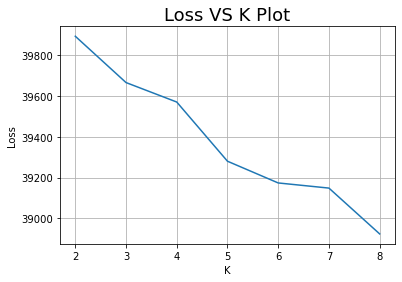

In [65]:
plt.plot(k_values, loss)
plt.xlabel('K')
plt.ylabel('Loss')
plt.title('Loss VS K Plot',size=18)
plt.grid()
plt.show()

#### observations:
1.we found optimal cluster value is 6


In [66]:
optimal_K=6
kmeans = KMeans(n_clusters=optimal_K, n_jobs=-1).fit(X_train_fe_5000)

In [67]:
kmeans.n_clusters

6

In [68]:
kmeans.labels_

array([3, 3, 2, ..., 2, 2, 3])

In [69]:

print(len(kmeans.labels_))

33500


In [70]:
clusters_set = {i: np.where(kmeans.labels_ == i)[0] for i in range(kmeans.n_clusters)}
clusters_set

{0: array([    9,    27,    33,    50,    53,    77,   142,   145,   159,
          185,   208,   214,   215,   231,   286,   313,   319,   326,
          358,   452,   537,   568,   596,   614,   686,   697,   739,
          741,   750,   756,   774,   923,  1013,  1016,  1020,  1052,
         1147,  1200,  1228,  1231,  1249,  1267,  1360,  1393,  1426,
         1460,  1486,  1539,  1550,  1606,  1607,  1622,  1646,  1683,
         1700,  1873,  1880,  1895,  1918,  1975,  1979,  1995,  2003,
         2054,  2055,  2101,  2143,  2191,  2206,  2218,  2259,  2307,
         2312,  2352,  2361,  2378,  2404,  2506,  2540,  2584,  2602,
         2607,  2617,  2625,  2661,  2666,  2719,  2752,  2754,  2872,
         2892,  2945,  2974,  3021,  3082,  3136,  3139,  3149,  3289,
         3337,  3464,  3480,  3501,  3624,  3686,  3763,  3785,  3805,
         3810,  3930,  3942,  3944,  3993,  3995,  4002,  4048,  4056,
         4117,  4125,  4141,  4162,  4164,  4235,  4243,  4266,  4274,
   

In [71]:
essays = preprocessed_essays

cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []
cluster6 = []
for i in range(kmeans.labels_.shape[0]):
    if kmeans.labels_[i] == 0:
        cluster1.append(essays[i])
    elif kmeans.labels_[i] == 1:
        cluster2.append(essays[i])
    elif kmeans.labels_[i] == 2:
        cluster3.append(essays[i])
    elif  kmeans.labels_[i] == 3:
        cluster4.append(essays[i])
    elif  kmeans.labels_[i] == 4:
        cluster5.append(essays[i])
    elif  kmeans.labels_[i] == 5:
        cluster6.append(essays[i])

In [72]:
#https://stackoverflow.com/a/306417
import random
print('%s'%(random.choice(cluster1)))

my class diverse i group students benefit additional intervention not common techniques we also steam classroom participate many hands activities really keep kids involved students class able take responsibility learning we not strictly book class they able help guide go year this makes learning student centered exciting kids these tools used regularly classroom every day the osmo system multifaceted give kids opportunity would not otherwise creative technology the building supplies much needed my students able build create using items help retain information they excited learn i want kids look forward coming class day i want classroom tools necessary encourage stay positive let know much i believe nannan


In [73]:
#https://www.datacamp.com/community/tutorials/wordcloud-python

from PIL import Image
wine_mask = np.array(Image.open("wine_mask.png"))
wine_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [74]:
def transform_format(val):
    
    if val == 0:
        return 255
    else:
        return val

In [75]:
transformed_wine_mask = np.ndarray((wine_mask.shape[0],wine_mask.shape[1]), np.int32)

for i in range(len(wine_mask)):
    transformed_wine_mask[i] = list(map(transform_format, wine_mask[i]))

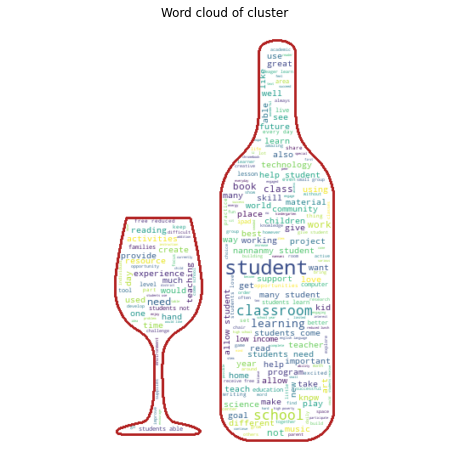

In [76]:
words=''
for i in cluster1:
    words+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white", max_words=1000, mask=transformed_wine_mask,
               stopwords=stopwords, contour_width=3, contour_color='firebrick').generate(words)

# Display the generated image:
plt.figure(figsize=[16,8])
plt.title("Word cloud of cluster")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [77]:
print('%s'%(random.choice(cluster2)))

imagine first generation family receive formal education now imagine also english language learner these kids some new comers country no prior education english our school made 94 economically disadvantaged families the majority students limited support resources home this makes time class even precious however despite obstacles bright determined excited learn research shows students develop second language proficiency much faster strong foundation maternal language for class 19 bilingual kids means reading listening stories spanish over years i acquired quite classroom library lacking spanish high interest books with books kids fully enthralled read alouds they excited shop books collection place independent reading bags then throughout week i certain eager focused reading fun books independently from reading fluency comprehension skyrocket nannan


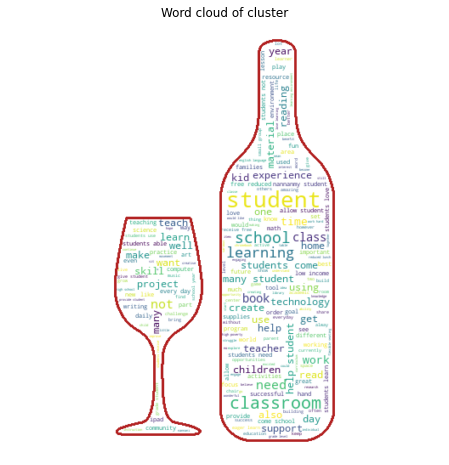

In [78]:
words=''
for i in cluster2:
    words+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white", max_words=1000, mask=transformed_wine_mask,
               stopwords=stopwords, contour_width=3, contour_color='firebrick').generate(words)

# Display the generated image:
plt.figure(figsize=[16,8])
plt.title("Word cloud of cluster")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [79]:
print('%s'%(random.choice(cluster3)))

i work small fully inclusive charter school almost 90 students receive free reduced lunch i work students labeled many ways ell ld id bip iep slp apraxic autistic add adhd odd list goes i working help students remove labels find feet well voices my students come variety backgrounds one thing common thirst creative learning opportunities no one ever accuse artist my lack ability not deter search creative art activities integrate multiple subject areas origami connect fine motor art activities math science research projects enhance outcomes energize connections students make when thinking integrating steam activities round classroom instruction i keep mind seating center organization the table stools offer storage allow create vibrant learning environment paper art collide coming alive hands students nannan


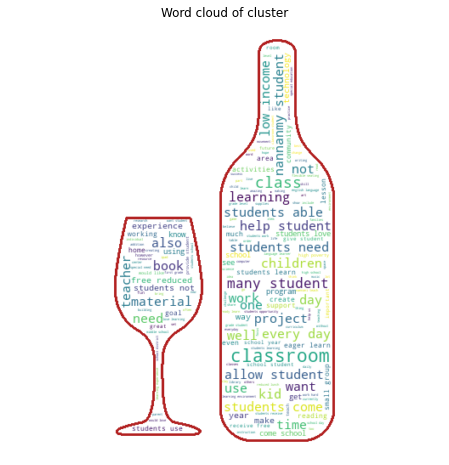

In [80]:
words=''
for i in cluster3:
    words+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white", max_words=1000, mask=transformed_wine_mask,
               stopwords=stopwords, contour_width=3, contour_color='firebrick').generate(words)

# Display the generated image:
plt.figure(figsize=[16,8])
plt.title("Word cloud of cluster")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [81]:
print('%s'%(random.choice(cluster4)))

my 5th graders awesome kids the students variety education levels interests my kiddos gain education hands activities active lessons i love reading i teach love read i teach high poverty community kids arrive school excited routine day my students experience world books i teach students question situations think outside box push limits i want students want school they come school not learn love loved fellow classmates we strive family respects ideas inspire dream big these books improve lives giving better understanding grammar techniques as well giving books read aloud school day i use read alouds reinforce reading grammar lessons these books allow students hear story well see examples listening story i use chapter books help teach reading lessons the students enjoy listening characters learning speaking listening standards reading also great way teach ela standards literature standards nannan


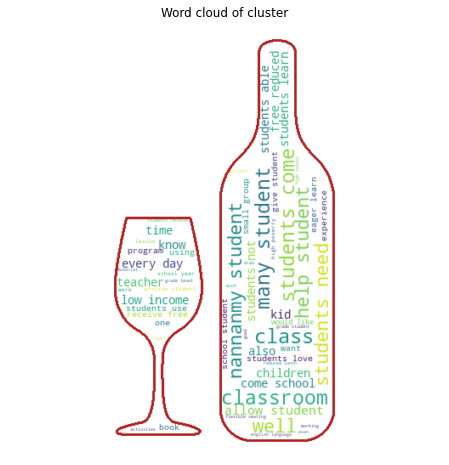

In [82]:
words=''
for i in cluster4:
    words+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white", max_words=1000, mask=transformed_wine_mask,
               stopwords=stopwords, contour_width=3, contour_color='firebrick').generate(words)

# Display the generated image:
plt.figure(figsize=[16,8])
plt.title("Word cloud of cluster")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [83]:
print('%s'%(random.choice(cluster5)))

my students diverse group children various interests learning styles many students english language learners they ambitious hard working they curious variety topics vibrant imaginations my students look reading learn interests read characters identify i hope nurture students love reading providing books thoroughly enjoy appreciate the books donated project help students fall love learning allowing read stories interested a lot time students not enjoy reading simply not found right book by collecting library books appeals variety interests diversity students students able better identify characters read the wide variety books included project ensure students represented classroom library nannan


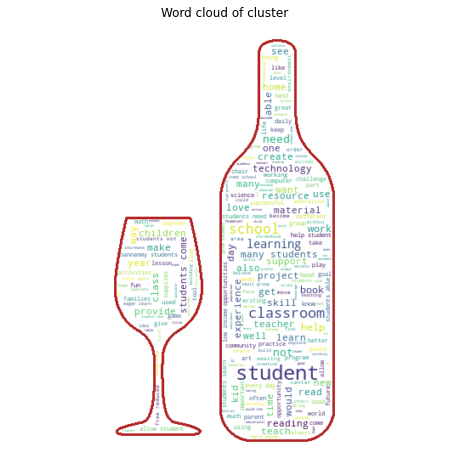

In [84]:
words=''
for i in cluster5:
    words+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white", max_words=1000, mask=transformed_wine_mask,
               stopwords=stopwords, contour_width=3, contour_color='firebrick').generate(words)

# Display the generated image:
plt.figure(figsize=[16,8])
plt.title("Word cloud of cluster")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [85]:
print('%s'%(random.choice(cluster6)))

my population unique living hospital i teach they hospitalized emotional intellectual disabilities most students come broken homes foster care their level safety coping skills day day life compromised due prolonged abuse witnessing domestic violence drug alcohol abuse mental illness my students need materials help express discover academics fun the supplies i requested already direction they beaiding students furthering artistiic voice they learn art ever changing narrative multiple directions supplies help substantiate creativity the supplies help support students come classroom starting paint different masks learn use colors textures create furthering artistic scope the extra help supplies also generates avenues create inspirational projects especially since students transitional change frequently due school hospital setting nannan


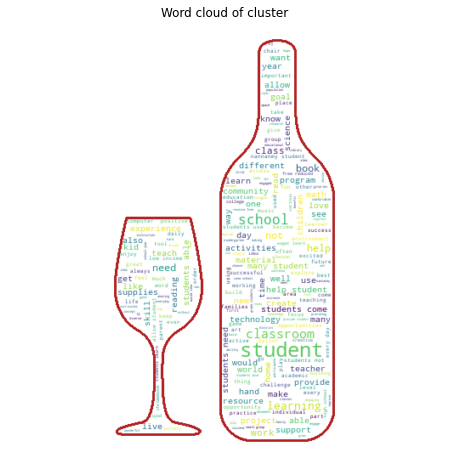

In [86]:
words=''
for i in cluster6:
    words+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white", max_words=1000, mask=transformed_wine_mask,
               stopwords=stopwords, contour_width=3, contour_color='firebrick').generate(words)

# Display the generated image:
plt.figure(figsize=[16,8])
plt.title("Word cloud of cluster")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## 5.Apply Agglomerative Clustering

## 5.1 view of Agglomerative Clustering

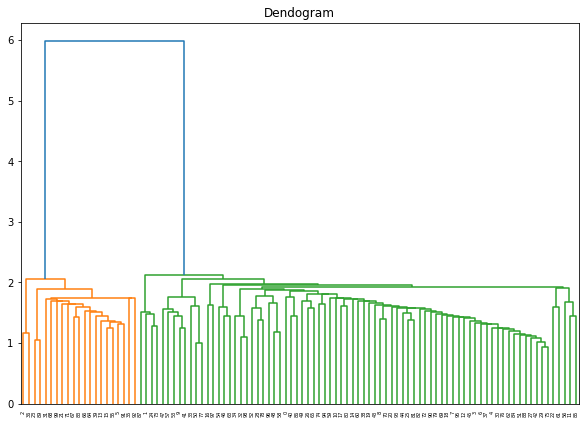

In [87]:
import scipy.cluster.hierarchy as shc
X_train = X_train_fe_5000[:100]
X_tr = X_train.toarray()

algo_title = 'Agglomerative Clustering'
plt.figure(figsize=(10, 7))  
plt.title("Dendogram")  
dend = shc.dendrogram(shc.linkage(X_tr, method='ward'))

In [88]:
X_train_fe_5000_new = X_train_fe_5000[:2500]

In [89]:
X_train_fe_5000_new.shape

(2500, 5000)

### 5.2 apply Agglomerative Clustering

In [90]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
clusters=[2,3,5,7]
scores = []
for i in clusters:
    aggcl=AgglomerativeClustering(n_clusters=i).fit(X_train_fe_5000_new.toarray())
    score=silhouette_score(X_train_fe_5000_new, aggcl.labels_, random_state=42)
    scores.append(score)

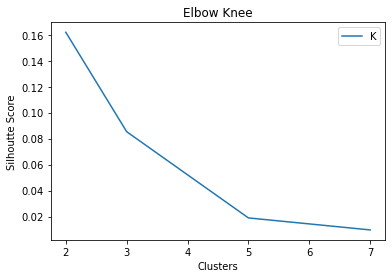

In [91]:
plt.plot(clusters, scores)
plt.xlabel('Clusters')
plt.ylabel('Silhoutte Score')
plt.title('Elbow Knee')
plt.legend('Knee')
plt.show()


#### observations:
1.Best value for cluster is 3 

In [92]:
from sklearn.cluster import AgglomerativeClustering

aggcl=AgglomerativeClustering(n_clusters=3).fit(X_train_fe_5000_new.toarray())

In [93]:
clustera0=[]
clustera1=[]
clustera2=[]

essays = preprocessed_essays
for i in range(aggcl.labels_.shape[0]):
    if aggcl.labels_[i] == 0:
        clustera0.append(essays[i])
    elif aggcl.labels_[i] == 1:
        clustera1.append(essays[i])
    elif aggcl.labels_[i] == 2:
        clustera2.append(essays[i])
   
        

In [94]:
print('%s'%(random.choice(clustera0)))

remember saying a picture is worth thousand words this using technology study math science students i 40 hard working willing learn students delta they attend rural title i school delta limited outdated technology classroom they love working technology order compete today society need use updated technology work high school advanced science fuses together extensive curriculum bursting seams historical breakthroughs abstract ideas to effectively investigate topics essential employ multitude practical hands activities full enriching inspiring activities the laptop essential tool associated accomplishing goals unlock limitless techniques accommodate diverse learning styles among students each science content standards strengthened incorporating advantageous technology there thousands educational apps enlighten students eco friendly apps space exploration dissection human body weather geography mathematics reading textbooks various apps appeal virtually student interest with valuable resou

### Wordcloud for clusters

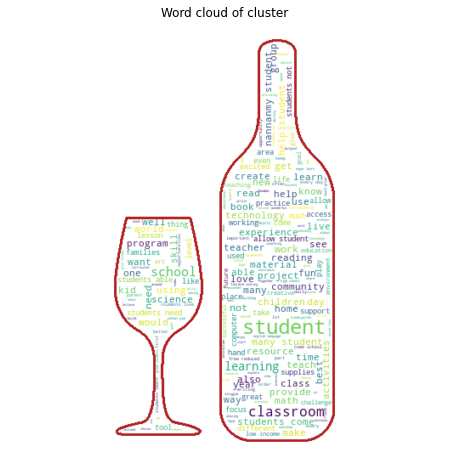

In [95]:
words=''
for i in clustera0:
    words+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white", max_words=1000, mask=transformed_wine_mask,
               stopwords=stopwords, contour_width=3, contour_color='firebrick').generate(words)

# Display the generated image:
plt.figure(figsize=[16,8])
plt.title("Word cloud of cluster")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [96]:
print('%s'%(random.choice(clustera1)))

i work title one school we provide free breakfast lunch students i 27 students class list my students combination english ell students i privilege teaching kindergartners many students come low income families many come not prepare school due lack funds home they sometimes unable complete homework not supplies home as teacher i try provide much i order succeed i requesting school supplies it difficult complete class work homework without basic school supplies our class use glue sticks every day complete projects class work pencils must students write every day difficult complete assignments lost taken home pencils crayons it important basic necessities sometimes difficult buy money issue in order students succeed basic needs must met please help class funding project my students greatly appreciate nannan


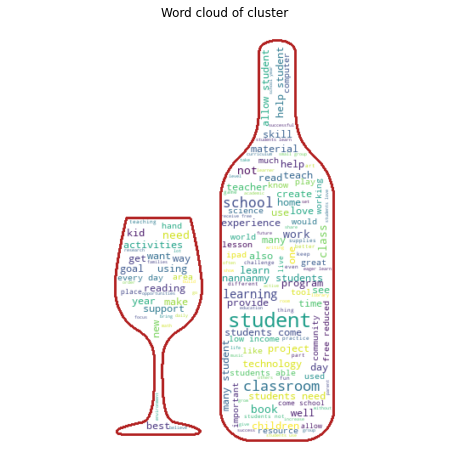

In [97]:

words=''
for i in clustera1:
    words+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white", max_words=1000, mask=transformed_wine_mask,
               stopwords=stopwords, contour_width=3, contour_color='firebrick').generate(words)

# Display the generated image:
plt.figure(figsize=[16,8])
plt.title("Word cloud of cluster")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()










In [98]:
print('%s'%(random.choice(clustera2)))

my students blended classroom consists diverse crowd special needs students english language learners students general education population their age range three five years old as special education teacher i serve diverse crowd students special needs the students i serve mostly african american hispanic my students come low socioeconomic circumstances the parents community try best support students these students inspire better teacher person i learn daily the uniqueness students brings class unimaginable dr seuss quotes the read things know the learn places go i could not agree statement reading important part life when read young children not opens imaginations also expands knowledge world it helps develop necessary language listening skills need successful school well prepares understand importance written words that everyday make one main priorities blended preschool program read the amount knowledge students develop short amount time taking part read aloud book browsing astonishes

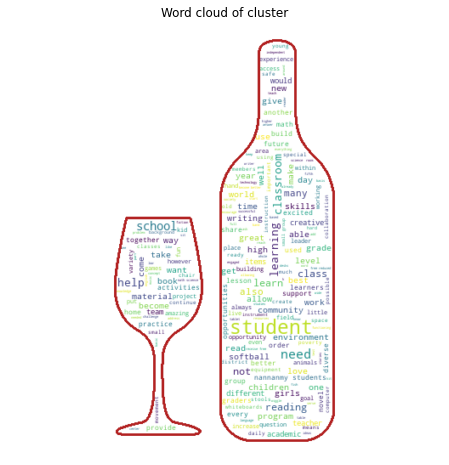

In [99]:

words=''
for i in clustera2:
    words+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white", max_words=1000, mask=transformed_wine_mask,
               stopwords=stopwords, contour_width=3, contour_color='firebrick').generate(words)

# Display the generated image:
plt.figure(figsize=[16,8])
plt.title("Word cloud of cluster")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()









## 6 Apply DBSCAN

100%|██████████| 2500/2500 [01:14<00:00, 33.51it/s]


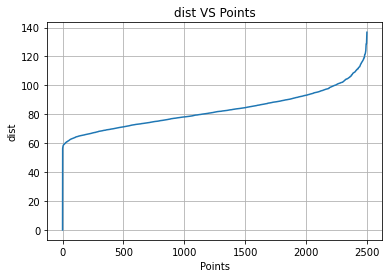

In [100]:
min_points = 1000
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances

dbScanData=StandardScaler().fit_transform(X_train_fe_5000_new.toarray())

distance=[]
for point in tqdm(dbScanData):
    temp = euclidean_distances(dbScanData, point.reshape(1, -1))
    distance.append(temp[min_points])
sorted_distance = np.sort(np.array(distance))

sorted_dist = np.sort(sorted_distance.reshape(1,-1)[0])
points = [i for i in range(len(dbScanData))]


# Draw distances(d_i) VS points(x_i) plot
plt.plot(points, sorted_dist)
plt.xlabel('Points')
plt.ylabel('dist')
plt.title('dist VS Points')
plt.grid()
plt.show()

In [101]:
#we can see that point of inflexion is at eps=65
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=65,n_jobs=-1)
dbscan.fit(dbScanData)
print('No of clusters: ',len(set(dbscan.labels_)))
print('Cluster are including noise i.e -1: ',set(dbscan.labels_))

No of clusters:  2
Cluster are including noise i.e -1:  {0, -1}


In [102]:
#ignoring -1 as it is for noise
cluster1=[]
noisecluster1=[]
for i in range(dbscan.labels_.shape[0]):
    if dbscan.labels_[i] == 0:
        cluster1.append(essays[i])
    elif dbscan.labels_[i] == -1:
        noisecluster1.append(essays[i])

In [103]:
print('%s'%(random.choice(cluster1)))

some students difficult time staying task small groups especially guided reading math these wobble chairs might key unlocking energy wiggle release would allow move focus i work small inclusive charter school small playground virtually no fields run i work using movement classroom allow students bit energy release my school allows lot creative vision i hope expand classroom creating different types learning stations the wobble chairs would add kinesthetic element guided reading math my guided reading math station need reenergized i think wobble chairs help build reading stamina better focus 3rd graders endless energy a recess not enough time release amount energy students come class i think small limited amount movement i see increase focus interest also math reading acquisition they not dread guided reading guided math station longer i think donation 6 wobble chairs help students acquire necessary math reading skills increase focus stamina interest my classroom sensory experience my s

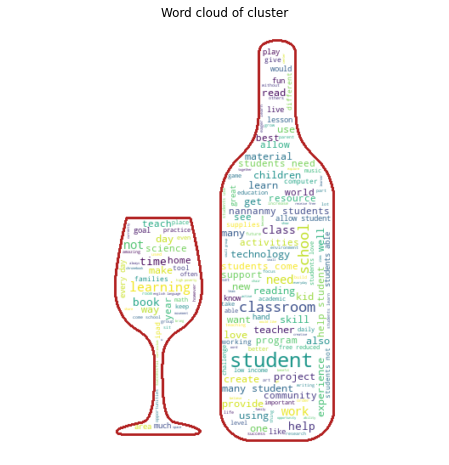

In [104]:

words=''
for i in cluster1:
    words+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white", max_words=1000, mask=transformed_wine_mask,
               stopwords=stopwords, contour_width=3, contour_color='firebrick').generate(words)

# Display the generated image:
plt.figure(figsize=[16,8])
plt.title("Word cloud of cluster")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()









In [105]:
print('%s'%(random.choice(noisecluster1)))

our school located rural area approximately 650 students grades 6 8 the library meeting place student morning well lunchtime we trying modernize library meet needs students students love come library hang using different seating arrangements currently two high boy tables students requested cool places please consider helping us make reality students last year decided overhaul library one popular projects taking old card catalog turning highboy table students this become favorite spot students process creating another one an additional project taken adding overhang onto 24 foot long book shelf this another place students sit work your donation would allow us purchase stools used two new seating areas we want make library place students want middle school tough many students having safe comfortable welcoming place go something students need nannan


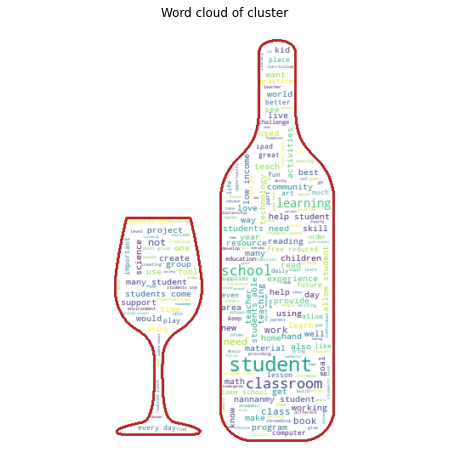

In [106]:

words=''
for i in noisecluster1:
    words+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white", max_words=1000, mask=transformed_wine_mask,
               stopwords=stopwords, contour_width=3, contour_color='firebrick').generate(words)

# Display the generated image:
plt.figure(figsize=[16,8])
plt.title("Word cloud of cluster")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()










## 7.Pretty Table

In [110]:
#prettytable for kmeans
from prettytable import PrettyTable    
x = PrettyTable()
x.field_names = ["Model","BEST K","Eps","Number of clusters(INCLUDING NOISE)"]

x.add_row(['KMEANS','6','NA','NA'])
x.add_row(['AGGLOMERATIVE','3','NA','NA'])

x.add_row(['DBSCAN','2',65,2])
                 
print(x)

+---------------+--------+-----+-------------------------------------+
|     Model     | BEST K | Eps | Number of clusters(INCLUDING NOISE) |
+---------------+--------+-----+-------------------------------------+
|     KMEANS    |   6    |  NA |                  NA                 |
| AGGLOMERATIVE |   3    |  NA |                  NA                 |
|     DBSCAN    |   2    |  65 |                  2                  |
+---------------+--------+-----+-------------------------------------+


## 8.Conclusion

1.Plot word cloud for every cluster and show top words from each cluster.

2.Some clusters are dense

3.Found optimal clusters 3 and 6 in Kmeans and Agglomrtative 

4.We use euclidean distance to find best eps= in DBSCAN